## Import Dataset

In [189]:
import sklearn
import imblearn
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import statsmodels.api as sm
import random
import os

from sklearn.svm import SVC  # Importing Support Vector Classifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE  # For oversampling
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Layer, Softmax, Activation, Conv1D, MaxPooling1D, Flatten, LSTM, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

In [190]:
df_sar = pd.read_csv('../datasets/sarcasm_final.csv')
df_sar.columns

Index(['Unnamed: 0', 'sarcasm_label', 'emotion_label', 'sentiment_label', 'id',
       'spectral_centroid', 'spectral_bandwidth', 'pitch', 'PCA_MFCC_1',
       'PCA_MFCC_2', 'PCA_MFCC_3', 'PCA_MFCC_4', 'PCA_MFCC_5', 'PCA_MFCC_6',
       'PCA_MFCC_7', 'PCA_MFCC_8', 'sentence_level_similarity_emotion',
       'sentence_level_similarity_word', 'exclamation', 'PCA_W2V_1',
       'PCA_W2V_2', 'PCA_W2V_3', 'PCA_W2V_4', 'PCA_W2V_5', 'PCA_W2V_6',
       'PCA_W2V_7', 'PCA_W2V_8', 'PCA_W2V_9', 'PCA_W2V_10', 'PCA_W2V_11',
       'PCA_W2V_12', 'PCA_W2V_13', 'PCA_W2V_14', 'PCA_W2V_15', 'PCA_W2V_16',
       'PCA_W2V_17', 'PCA_W2V_18', 'PCA_W2V_19', 'PCA_W2V_20', 'PCA_W2V_21',
       'PCA_W2V_22', 'PCA_W2V_23', 'PCA_W2V_24', 'PCA_W2V_25', 'PCA_W2V_26',
       'PCA_W2V_27', 'PCA_W2V_28', 'PCA_W2V_29', 'PCA_W2V_30', 'PCA_W2V_31',
       'PCA_W2V_32', 'PCA_W2V_33', 'PCA_W2V_34', 'PCA_W2V_35', 'PCA_W2V_36',
       'PCA_W2V_37', 'PCA_W2V_38', 'PCA_W2V_39', 'PCA_W2V_40', 'PCA_W2V_41',
       'PCA_W2V_42', 

## Baseline Model for Sarcasm

In [191]:
# Define all the feature columns (text + audio features)
all_feature_columns = [
    'sentence_level_similarity_emotion', 'sentence_level_similarity_word', 'exclamation'
] + [f'PCA_W2V_{i}' for i in range(1, 9)] + [
    'spectral_centroid', 'spectral_bandwidth', 'pitch'
] + [f'PCA_MFCC_{i}' for i in range(1, 9)]

# Select a subset of text features for the text-only model
feature_columns_text = [
    'sentence_level_similarity_emotion', 'sentence_level_similarity_word', 'exclamation'
] + [f'PCA_W2V_{i}' for i in range(1, 9)]

# Select a subset of audio features for the text-only model
feature_columns_audio = [
    'spectral_centroid', 'spectral_bandwidth', 'pitch'
] + [f'PCA_MFCC_{i}' for i in range(1, 9)]

In [192]:
# target prediction
target_column = 'sarcasm_label'

# Prepare the feature set and target column for both models
X_all = df_sar[all_feature_columns]
y = df_sar[target_column]

# Function to scale, split, and apply SMOTE
def preprocess_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, X_test, y_train_resampled, y_test

# --- Text-Only Model ---
X_text = df_sar[feature_columns_text]
X_train_text, X_test_text, y_train_text, y_test_text = preprocess_data(X_text, y)

# --- Audio-Only Model --- this is for following hybrid model
X_audio = df_sar[feature_columns_audio]
X_train_audio, X_test_audio, y_train_audio, y_test_audio = preprocess_data(X_audio, y)

### Comparing Text-only Model and Combined Model

In [193]:
# Logistic Regression with text features
logistic_model_text = LogisticRegression(max_iter=500, random_state=42)
logistic_model_text.fit(X_train_text, y_train_text)

# Predict on the test set
y_pred_text = logistic_model_text.predict(X_test_text)

# --- Combined Model (Text + Audio Features) ---
X_train_combined, X_test_combined, y_train_combined, y_test_combined = preprocess_data(X_all, y)

# Logistic Regression with both text and audio features
logistic_model_combined = LogisticRegression(max_iter=500, random_state=42)
logistic_model_combined.fit(X_train_combined, y_train_combined)

# Predict on the test set
y_pred_combined = logistic_model_combined.predict(X_test_combined)
y_pred_logistic_proba = logistic_model_combined.decision_function(X_test_combined)

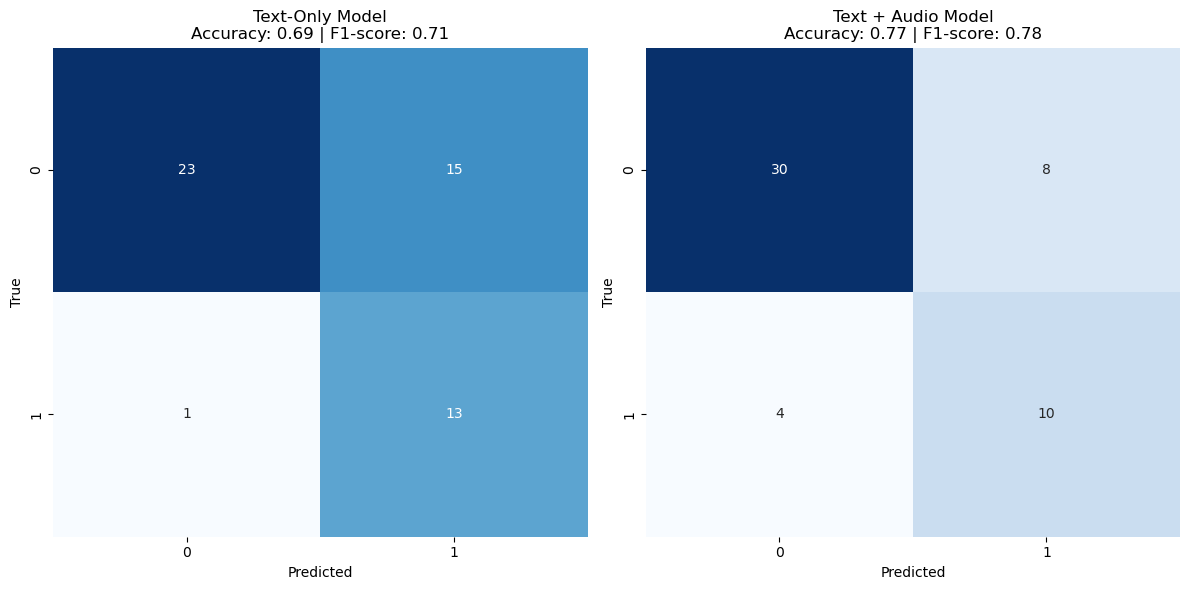

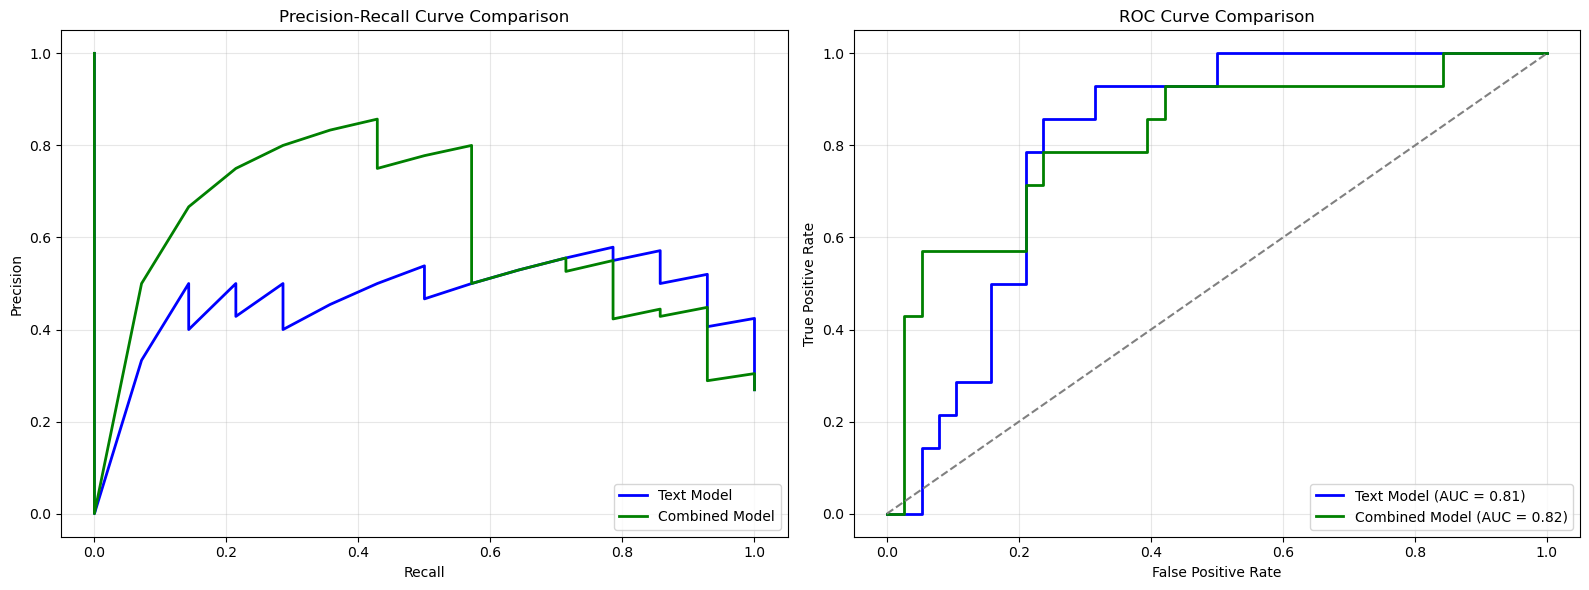


Comparison of Model Performance:
Accuracy with Text Features: 0.69
Accuracy with Text and Audio Features: 0.77


In [199]:
# Evaluation Results (Text-Only Model)
accuracy_text = accuracy_score(y_test_text, y_pred_text)
cm_text = confusion_matrix(y_test_text, y_pred_text)
f1_text = f1_score(y_test_text, y_pred_text, average='weighted')
cr_text = classification_report(y_test_text, y_pred_text, output_dict=True)

# Evaluation Results (Combined Model)
accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
cm_combined = confusion_matrix(y_test_combined, y_pred_combined)
f1_combined = f1_score(y_test_combined, y_pred_combined, average='weighted')
cr_combined = classification_report(y_test_combined, y_pred_combined, output_dict=True)

# Display the confusion matrix for both models
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Text-Only Model Confusion Matrix
sns.heatmap(cm_text, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0])
ax[0].set_title(f'Text-Only Model\nAccuracy: {accuracy_text:.2f} | F1-score: {f1_text:.2f}')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Combined Model Confusion Matrix
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1])
ax[1].set_title(f'Text + Audio Model\nAccuracy: {accuracy_combined:.2f} | F1-score: {f1_combined:.2f}')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('../image/text_vs_combine_confusion.png')
plt.show()

# Plot ROC Curve for both models
fpr_text, tpr_text, _ = roc_curve(y_test_text, logistic_model_text.predict_proba(X_test_text)[:, 1])
fpr_combined, tpr_combined, _ = roc_curve(y_test_combined, logistic_model_combined.predict_proba(X_test_combined)[:, 1])

roc_auc_text = auc(fpr_text, tpr_text)
roc_auc_combined = auc(fpr_combined, tpr_combined)

# Plot Precision-Recall Curve for both models
precision_text, recall_text, _ = precision_recall_curve(y_test_text, logistic_model_text.predict_proba(X_test_text)[:, 1])
precision_combined, recall_combined, _ = precision_recall_curve(y_test_combined, logistic_model_combined.predict_proba(X_test_combined)[:, 1])

# Set up a figure with 1 row and 2 columns for subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC Curve
ax[1].plot(fpr_text, tpr_text, color='blue', lw=2, label=f'Text Model (AUC = {roc_auc_text:.2f})')
ax[1].plot(fpr_combined, tpr_combined, color='green', lw=2, label=f'Combined Model (AUC = {roc_auc_combined:.2f})')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve Comparison')
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3)

# Plot Precision-Recall Curve
ax[0].plot(recall_text, precision_text, color='blue', lw=2, label='Text Model')
ax[0].plot(recall_combined, precision_combined, color='green', lw=2, label='Combined Model')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve Comparison')
ax[0].legend(loc='lower right')
ax[0].grid(alpha=0.3)

# Adjust layout for better visualization
plt.tight_layout()
plt.savefig('../image/text_vs_combine_roc_and_pr_curves.png')
plt.show()

# Comparison Summary of Accuracies
print("\nComparison of Model Performance:")
print(f"Accuracy with Text Features: {accuracy_text:.2f}")
print(f"Accuracy with Text and Audio Features: {accuracy_combined:.2f}")

So, adding audio features improves the model’s ability to predict sarcasm labels. This improvement is evidenced by higher accuracy, better true positive rates, and enhanced performance metrics (Precision-Recall and ROC AUC). Audio cues likely provide additional context or tone information, which complements textual analysis in detecting sarcasm. It is also noteworthy that there is a higher incidence of misclassification for instances that are sarcastic but are predicted as non-sarcastic.

Go deep to identify the most significant predictors

Optimization terminated successfully.
         Current function value: 0.318500
         Iterations 8


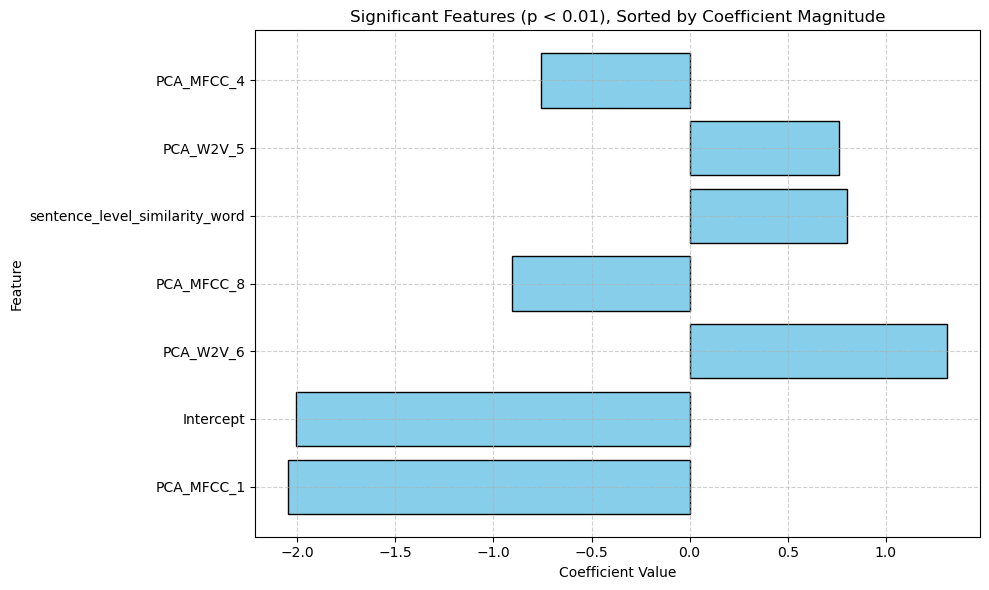

In [170]:
# Assuming X_text.columns contains the correct feature names
feature_names = ['Intercept'] + list(X_all.columns)

# Add an intercept to the combined dataset
X_train_combined_with_intercept = sm.add_constant(X_train_combined)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train_combined, X_train_combined_with_intercept)
result = logit_model.fit()

# Convert the result summary to a DataFrame and replace the index with feature names
summary_table = result.summary2().tables[1]  # Get the coefficient table
summary_table.index = feature_names  # Replace generic 'x1', 'x2', ... with actual names

sorted_summary = summary_table.sort_values(by='P>|z|')

# Identify significant features based on p-value
significant_features = summary_table[summary_table['P>|z|'] < 0.01]

# Sort significant features by the absolute value of their coefficients
significant_features_sorted = significant_features.reindex(
    significant_features['Coef.'].abs().sort_values(ascending=False).index
)

# Plot the coefficients of significant features as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(significant_features_sorted.index, significant_features_sorted['Coef.'], color='skyblue', edgecolor='black')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Features (p < 0.01), Sorted by Coefficient Magnitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('../image/signficant_coef.png')
plt.show()

Features such as PCA_MFCCs_1 and PCA_MFCCs_8 (derived from audio) and PCA_W2V_6 and sentence_level_similarity_word (derived from text) play a key role in the combined model of text and audio for predicting the sarcasm label.

## Improve Combined Model

### Machine Learning Approach (SVM and Naive Bayes)

#### SVM

In [171]:
# Support Vector Machine (SVM) Model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_combined, y_train_combined)

# Predict with SVM
y_pred_svm = svm_model.predict(X_test_combined)
# Calculate probabilities for SVM
y_pred_svm_proba = svm_model.decision_function(X_test_combined)  # For SVM, use decision_function for Precision-Recall


# Evaluate SVM Model
print("\nSupport Vector Machine (SVM) Results:")
print(f"Accuracy: {accuracy_score(y_test_combined, y_pred_svm):.2f}")
print("Classification Report:\n", classification_report(y_test_combined, y_pred_svm))


Support Vector Machine (SVM) Results:
Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85        38
           1       0.59      0.71      0.65        14

    accuracy                           0.79        52
   macro avg       0.74      0.77      0.75        52
weighted avg       0.81      0.79      0.79        52



#### Naive Bayes

In [172]:
# Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train_combined, y_train_combined)
y_pred_nb_proba = nb_model.predict(X_test_combined)

# Evaluate Naive Bayes Model
print("\nNaive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test_combined, y_pred_nb_proba):.2f}")
print("Classification Report:\n", classification_report(y_test_combined, y_pred_nb_proba))


Naive Bayes Results:
Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83        38
           1       0.55      0.79      0.65        14

    accuracy                           0.77        52
   macro avg       0.73      0.77      0.74        52
weighted avg       0.81      0.77      0.78        52



In [173]:
# Random Forest Model
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_combined, y_train_combined)

# Making predictions on the test set
y_pred_clf = clf_model.predict(X_test_combined)

# Calculating the accuracy
accuracy_clf = accuracy_score(y_test_combined, y_pred_clf)

# Generating a classification report
class_report = classification_report(y_test_combined, y_pred_clf)

# Printing out the results
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_clf:.2f}")
print("Classification Report:\n", class_report)


Random Forest Results:
Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        38
           1       0.67      0.57      0.62        14

    accuracy                           0.81        52
   macro avg       0.76      0.73      0.74        52
weighted avg       0.80      0.81      0.80        52



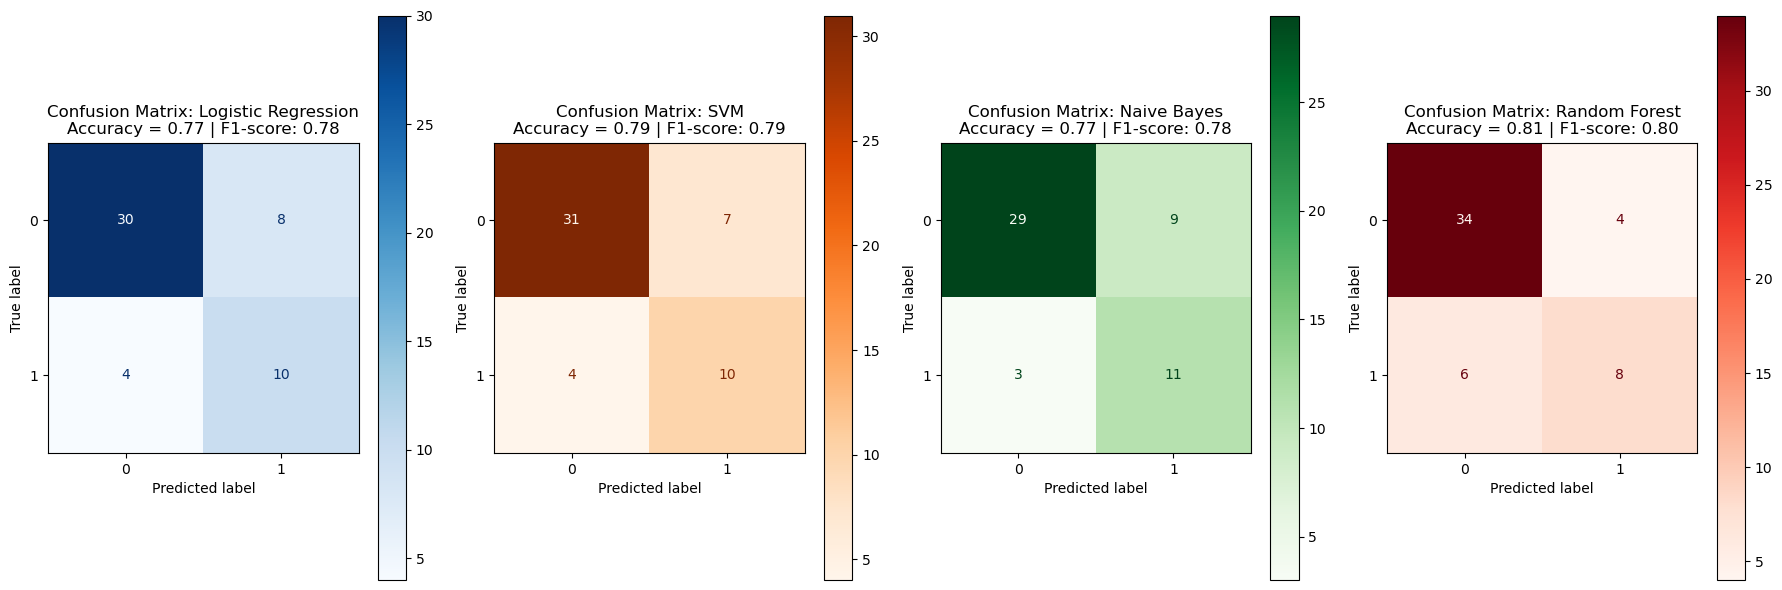

In [174]:
# Calculate accuracies for each model
accuracy_logistic = logistic_model_combined.score(X_test_combined, y_test_combined)
accuracy_svm = svm_model.score(X_test_combined, y_test_combined)
accuracy_nb = nb_model.score(X_test_combined, y_test_combined)
accuracy_clf = clf_model.score(X_test_combined, y_test_combined)  # Assuming clf_model is defined

# Predictions for F1 score calculation
y_pred_logistic = logistic_model_combined.predict(X_test_combined)
y_pred_svm = svm_model.predict(X_test_combined)
y_pred_nb = nb_model.predict(X_test_combined)
y_pred_clf = clf_model.predict(X_test_combined)

# Calculate F1-scores
f1_logistic = f1_score(y_test_combined, y_pred_logistic, average='weighted')
f1_svm = f1_score(y_test_combined, y_pred_svm, average='weighted')
f1_nb = f1_score(y_test_combined, y_pred_nb, average='weighted')
f1_clf = f1_score(y_test_combined, y_pred_clf, average='weighted')

# Set up a figure with 1 row and 4 columns for subplots
fig, ax = plt.subplots(1, 4, figsize=(18, 6))

# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_estimator(logistic_model_combined, X_test_combined, y_test_combined, cmap='Blues', ax=ax[0])
ax[0].set_title(f"Confusion Matrix: Logistic Regression\nAccuracy = {accuracy_logistic:.2f} | F1-score: {f1_logistic:.2f}")

# Support Vector Machine (SVM) Model Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_combined, y_test_combined, cmap='Oranges', ax=ax[1])
ax[1].set_title(f"Confusion Matrix: SVM\nAccuracy = {accuracy_svm:.2f} | F1-score: {f1_svm:.2f}")

# Naive Bayes Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_test_combined, y_test_combined, cmap='Greens', ax=ax[2])
ax[2].set_title(f"Confusion Matrix: Naive Bayes\nAccuracy = {accuracy_nb:.2f} | F1-score: {f1_nb:.2f}")

# Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_model, X_test_combined, y_test_combined, cmap='Reds', ax=ax[3])
ax[3].set_title(f"Confusion Matrix: Random Forest\nAccuracy = {accuracy_clf:.2f} | F1-score: {f1_clf:.2f}")

# Adjust layout for better visualization
plt.tight_layout()
plt.savefig('../image/combine_diffmodel_confusion.png')
plt.show()

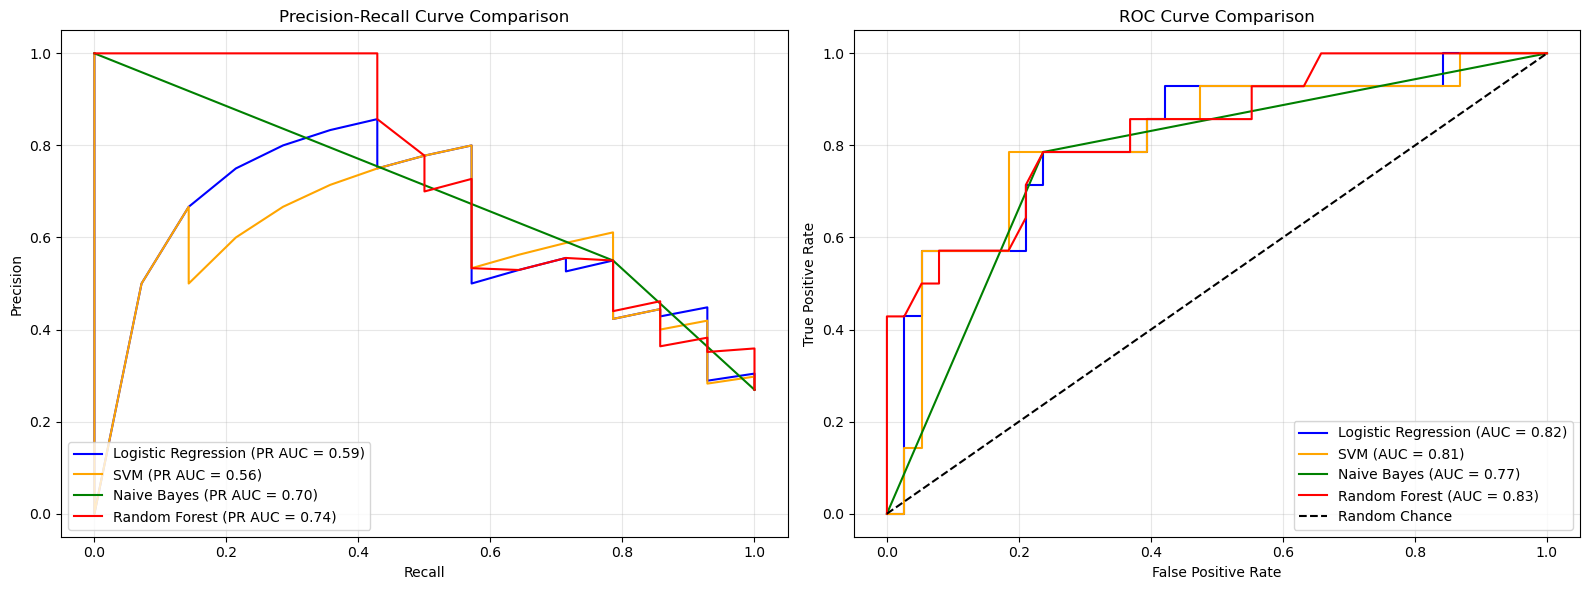

In [175]:
# Logistic Regression Precision-Recall
precision_logistic, recall_logistic, _ = precision_recall_curve(y_test_combined, y_pred_logistic_proba)
pr_auc_logistic = auc(recall_logistic, precision_logistic)

# SVM Precision-Recall
precision_svm, recall_svm, _ = precision_recall_curve(y_test_combined, y_pred_svm_proba)
pr_auc_svm = auc(recall_svm, precision_svm)

# Naive Bayes Precision-Recall
precision_nb, recall_nb, _ = precision_recall_curve(y_test_combined, y_pred_nb_proba)
pr_auc_nb = auc(recall_nb, precision_nb)

# Assuming clf_rf is your trained Random Forest classifier
y_pred_rf_proba = clf_model.predict_proba(X_test_combined)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test_combined, y_pred_rf_proba)
pr_auc_rf = auc(recall_rf, precision_rf)

# Compute ROC curves and AUC scores
fpr_logistic, tpr_logistic, _ = roc_curve(y_test_combined, y_pred_logistic_proba)
fpr_nb, tpr_nb, _ = roc_curve(y_test_combined, y_pred_nb_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_test_combined, y_pred_svm_proba)

auc_logistic = roc_auc_score(y_test_combined, y_pred_logistic_proba)
auc_svm = roc_auc_score(y_test_combined, y_pred_svm_proba)
auc_nb = roc_auc_score(y_test_combined, y_pred_nb_proba)

fpr_rf, tpr_rf, _ = roc_curve(y_test_combined, y_pred_rf_proba)
auc_rf = roc_auc_score(y_test_combined, y_pred_rf_proba)

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall Curve
ax[0].plot(recall_logistic, precision_logistic, label=f'Logistic Regression (PR AUC = {pr_auc_logistic:.2f})', color='blue')
ax[0].plot(recall_svm, precision_svm, label=f'SVM (PR AUC = {pr_auc_svm:.2f})', color='orange')
ax[0].plot(recall_nb, precision_nb, label=f'Naive Bayes (PR AUC = {pr_auc_nb:.2f})', color='green')
ax[0].plot(recall_rf, precision_rf, label=f'Random Forest (PR AUC = {pr_auc_rf:.2f})', color='red')  # Adding RF
ax[0].set_title('Precision-Recall Curve Comparison')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend(loc='lower left')
ax[0].grid(alpha=0.3)

# ROC Curve
ax[1].plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {auc_logistic:.2f})', color='blue')
ax[1].plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='orange')
ax[1].plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})', color='green')
ax[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='red')  # Adding RF
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Chance')
ax[1].set_title('ROC Curve Comparison')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('../image/combine_diffmodel_roc_and_pr_curves.png')
plt.show()

### Deep Learning Approach (FCNN, Hybird Model of )

#### Fully Connected Neural Network (FCNN)

In [176]:
# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Ensuring the same random seed is used every time before any layer weights are initialized
# Build a full connect neural network
model_FCNN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_combined.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_FCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_FCNN.fit(X_train_combined, y_train_combined, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
fcnn_loss, fcnn_accuracy = model_FCNN.evaluate(X_test_combined, y_test_combined)
print(f'FCNN Accuracy: {fcnn_accuracy}')

Epoch 1/50
8/8 [==============================] - 0s 9ms/step - loss: 0.7028 - accuracy: 0.5625 - val_loss: 0.7427 - val_accuracy: 0.3500
Epoch 2/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6473 - accuracy: 0.6167 - val_loss: 0.7474 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6082 - accuracy: 0.6542 - val_loss: 0.7224 - val_accuracy: 0.3667
Epoch 4/50
8/8 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.6625 - val_loss: 0.6994 - val_accuracy: 0.5500
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.6542 - val_loss: 0.6721 - val_accuracy: 0.6167
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7000 - val_loss: 0.6318 - val_accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.7167 - val_loss: 0.6096 - val_accuracy: 0.7833
Epoch 8/50
8/8 [==================

#### Enhenced FCNN

In [177]:
# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Build a more robust fully connected neural network
model_ehFCNN = Sequential([
    InputLayer(input_shape=(X_train_combined.shape[1],)),
    
    Dense(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    Dense(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

# Optimizer with a learning rate schedule
optimizer = Adam(learning_rate=0.001)
model_ehFCNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with validation split and callbacks
history = model_ehFCNN.fit(
    X_train_combined, 
    y_train_combined, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, model_checkpoint]
)

# Delete the best_model.h5 file
if os.path.exists('best_model.h5'):
    os.remove('best_model.h5')
    print('Deleted best_model.h5')
else:
    print('File best_model.h5 does not exist')

# Evaluate the model on the test set
fcnn_loss, fcnn_accuracy = model_ehFCNN.evaluate(X_test_combined, y_test_combined)
print(f'Enhanced FCNN Model Accuracy: {fcnn_accuracy}')

Epoch 1/50
8/8 [==============================] - 1s 17ms/step - loss: 1.6770 - accuracy: 0.5417 - val_loss: 1.5980 - val_accuracy: 0.6000
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.5622 - accuracy: 0.6333 - val_loss: 1.5440 - val_accuracy: 0.7667
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4832 - accuracy: 0.6667 - val_loss: 1.4917 - val_accuracy: 0.8000
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3554 - accuracy: 0.7792 - val_loss: 1.4372 - val_accuracy: 0.8333
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3600 - accuracy: 0.7417 - val_loss: 1.3852 - val_accuracy: 0.8667
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3163 - accuracy: 0.7833 - val_loss: 1.3280 - val_accuracy: 0.8667
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2524 - accuracy: 0.8000 - val_loss: 1.2801 - val_accuracy: 0.8833
Epoch 8/50
8/8 [=================

/Users/sicilywang/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 3ms/step - loss: 1.1203 - accuracy: 0.8583 - val_loss: 1.1749 - val_accuracy: 0.9167
Epoch 10/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.8625 - val_loss: 1.1214 - val_accuracy: 0.9167
Epoch 11/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0880 - accuracy: 0.8625 - val_loss: 1.0813 - val_accuracy: 0.9167
Epoch 12/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0532 - accuracy: 0.8417 - val_loss: 1.0403 - val_accuracy: 0.9167
Epoch 13/50
8/8 [==============================] - 0s 3ms/step - loss: 1.0380 - accuracy: 0.8500 - val_loss: 1.0034 - val_accuracy: 0.9167
Epoch 14/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9940 - accuracy: 0.8250 - val_loss: 0.9774 - val_accuracy: 0.9167
Epoch 15/50
8/8 [==============================] - 0s 3ms/step - loss: 0.9996 - accuracy: 0.8208 - val_loss: 0.9485 - val_accuracy: 0.9167
Epoch 16/50
8/8 [======================

Compare with previous FCNN, enhanced FCNN includes adjustments to the network architecture, incorporation of batch normalization and dropout, use of advanced activation functions, and applying techniques like regularization and optimizers with learning rate adjustments. Also includes callbacks for early stopping and model checkpointing to manage overfitting and save the best model during training.

#### Hybird Model

In [178]:
# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

def build_hybrid_model(num_text_features, num_audio_features):
    # Text input branch
    text_input = Input(shape=(num_text_features,), name='text_input')
    text_hidden = Dense(128, activation='relu')(text_input)
    text_hidden = Dropout(0.2)(text_hidden)
    
    # Audio input branch
    audio_input = Input(shape=(num_audio_features,), name='audio_input')
    audio_hidden = Dense(128, activation='relu')(audio_input)
    audio_hidden = Dropout(0.2)(audio_hidden)
    
    # Concatenate both branches
    concatenated = Concatenate()([text_hidden, audio_hidden])
    concatenated = Dense(64, activation='relu')(concatenated)
    concatenated = Dropout(0.2)(concatenated)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(concatenated)
    
    # Build and compile the model
    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Compile the model
model_hb = build_hybrid_model(num_text_features=11, num_audio_features=11)  # Update numbers based on actual feature count

# Train the model
history = model_hb.fit(
    [X_train_text, X_train_audio],
    y_train_combined,
    validation_data=([X_test_text, X_test_audio], y_test_combined),
    epochs=50,
    batch_size=32
)

# Evaluate the model
model_hb_accuracy = model_hb.evaluate([X_test_text, X_test_audio], y_test_combined)[1]
print("Hybird Model accuracy:", model_hb_accuracy)

Epoch 1/50
10/10 [==============================] - 0s 8ms/step - loss: 0.6716 - accuracy: 0.5933 - val_loss: 0.5913 - val_accuracy: 0.7885
Epoch 2/50
10/10 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.8000 - val_loss: 0.4923 - val_accuracy: 0.7308
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.8433 - val_loss: 0.4813 - val_accuracy: 0.7500
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8333 - val_loss: 0.4484 - val_accuracy: 0.7692
Epoch 5/50
10/10 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8567 - val_loss: 0.4515 - val_accuracy: 0.7500
Epoch 6/50
10/10 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.8567 - val_loss: 0.4700 - val_accuracy: 0.7500
Epoch 7/50
10/10 [==============================] - 0s 1ms/step - loss: 0.2933 - accuracy: 0.8733 - val_loss: 0.4838 - val_accuracy: 0.7692
Epoch 8/50
10/10 [==

#### Enhanced Hybird Model

In [179]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

def build_hybrid_model(num_text_features, num_audio_features, regularization_rate=0.01):
    # Text input branch
    text_input = Input(shape=(num_text_features,), name='text_input')
    text_hidden = Dense(128, activation='relu', kernel_regularizer=l2(regularization_rate))(text_input)
    text_hidden = BatchNormalization()(text_hidden)
    text_hidden = Dropout(0.3)(text_hidden)

    # Audio input branch
    audio_input = Input(shape=(num_audio_features,), name='audio_input')
    audio_hidden = Dense(128, activation='relu', kernel_regularizer=l2(regularization_rate))(audio_input)
    audio_hidden = BatchNormalization()(audio_hidden)
    audio_hidden = Dropout(0.3)(audio_hidden)

    # Concatenate both branches
    concatenated = Concatenate()([text_hidden, audio_hidden])
    concatenated = Dense(64, activation='relu', kernel_regularizer=l2(regularization_rate))(concatenated)
    concatenated = Dropout(0.3)(concatenated)

    # Output layer
    output = Dense(1, activation='sigmoid')(concatenated)

    # Build and compile the model
    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model_ehhb = build_hybrid_model(num_text_features=11, num_audio_features=11)

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Assume X_train_text, X_train_audio, y_train_combined are prepared
# and similarly for X_test_text, X_test_audio, y_test_combined
history = model_ehhb.fit(
    [X_train_text, X_train_audio],
    y_train_combined,
    validation_data=([X_test_text, X_test_audio], y_test_combined),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

# Delete the best_model.h5 file
if os.path.exists('best_model.h5'):
    os.remove('best_model.h5')
    print('Deleted best_model.h5')
else:
    print('File best_model.h5 does not exist')

# Evaluate the model
ehhb_accuracy = model_ehhb.evaluate([X_test_text, X_test_audio], y_test_combined)[1]
print("Hybrid Model Accuracy:", ehhb_accuracy)

Epoch 1/50
10/10 [==============================] - 0s 11ms/step - loss: 2.3218 - accuracy: 0.5667 - val_loss: 2.0001 - val_accuracy: 0.7115
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 1.8954 - accuracy: 0.7800 - val_loss: 1.8796 - val_accuracy: 0.7885
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 1.7625 - accuracy: 0.8067 - val_loss: 1.7990 - val_accuracy: 0.8077
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 1.6307 - accuracy: 0.8300 - val_loss: 1.7287 - val_accuracy: 0.8077
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 1.5967 - accuracy: 0.8467 - val_loss: 1.6713 - val_accuracy: 0.8269
Epoch 6/50
10/10 [==============================] - 0s 3ms/step - loss: 1.5287 - accuracy: 0.8333 - val_loss: 1.6163 - val_accuracy: 0.8077
Epoch 7/50
10/10 [==============================] - 0s 3ms/step - loss: 1.3967 - accuracy: 0.8833 - val_loss: 1.5673 - val_accuracy: 0.8077
Epoch 8/50
10/10 [=

Similar as above enhance the model by include a more sophisticated model architecture with enhanced training strategies like early stopping and model checkpoints. incorporate batch normalization and L2 regularization to help stabilize learning and mitigate overfitting.

Improving the enhanced hybrid model by integrating an attention mechanism

In [180]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Apply a simple dot product to get raw attention scores
        scores = K.dot(inputs, self.W)  # Shape: (batch_size, features, 1)

        # Use softmax directly without squeezing, across the features axis
        attention_weights = K.softmax(scores, axis=1)  # Softmax along the correct axis
        
        # Apply the attention weights, still maintaining batch and features dimension
        weighted_inputs = inputs * attention_weights  # Broadcasting to multiply weights
        output = K.sum(weighted_inputs, axis=1, keepdims=True)  # Sum over features, keep batch dimension

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)  # Output shape maintains the batch size and collapses features

In [181]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

def build_hybrid_model_with_attention(num_text_features, num_audio_features, regularization_rate=0.01):
    # Inputs
    text_input = Input(shape=(num_text_features,), name='text_input')
    audio_input = Input(shape=(num_audio_features,), name='audio_input')

    # Text processing branch
    text_hidden = Dense(128, activation='relu', kernel_regularizer=l2(regularization_rate))(text_input)
    text_hidden = BatchNormalization()(text_hidden)
    text_hidden = Dropout(0.3)(text_hidden)

    # Audio processing branch
    audio_hidden = Dense(128, activation='relu', kernel_regularizer=l2(regularization_rate))(audio_input)
    audio_hidden = BatchNormalization()(audio_hidden)
    audio_hidden = Dropout(0.3)(audio_hidden)

    # Concatenate both branches
    concatenated = Concatenate()([text_hidden, audio_hidden])

    # Apply attention
    attention_output = AttentionLayer()(concatenated)

    # Further processing after attention
    final_layer = Dense(64, activation='relu', kernel_regularizer=l2(regularization_rate))(attention_output)
    final_layer = Dropout(0.3)(final_layer)

    # Output layer
    output = Dense(1, activation='sigmoid')(final_layer)

    # Building and compiling the model
    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the enhanced model with attention
model_with_attention = build_hybrid_model_with_attention(num_text_features=11, num_audio_features=11)

# Fit the model
history = model_with_attention.fit(
    [X_train_text, X_train_audio],
    y_train_combined,
    validation_data=([X_test_text, X_test_audio], y_test_combined),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model
ehhbatt_accuracy = model_with_attention.evaluate([X_test_text, X_test_audio], y_test_combined)[1]
print("Enhanced Hybrid Model Accuracy with Attention:", ehhbatt_accuracy)

Epoch 1/50
10/10 [==============================] - 1s 58ms/step - loss: 2.4029 - accuracy: 0.5767 - val_loss: 1.7718 - val_accuracy: 0.7308
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 1.6887 - accuracy: 0.5800 - val_loss: 1.3225 - val_accuracy: 0.7308
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 1.8388 - accuracy: 0.5933 - val_loss: 1.2967 - val_accuracy: 0.7308
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 1.5370 - accuracy: 0.6333 - val_loss: 1.3445 - val_accuracy: 0.7308
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 1.4955 - accuracy: 0.5833 - val_loss: 1.2564 - val_accuracy: 0.7115
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 1.3365 - accuracy: 0.6167 - val_loss: 1.2115 - val_accuracy: 0.6923
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 1.5546 - accuracy: 0.6333 - val_loss: 1.2194 - val_accuracy: 0.7115
Epoch 8/50
10/10 [=

Attention not improve might because:

- Model Complexity: Adding an attention layer increases the complexity of your model. While attention is designed to help the model focus on the most relevant features, it also introduces additional parameters and complexity that might not be warranted given the data size or feature set.

2/2 [==============================] - 0s 1ms/step


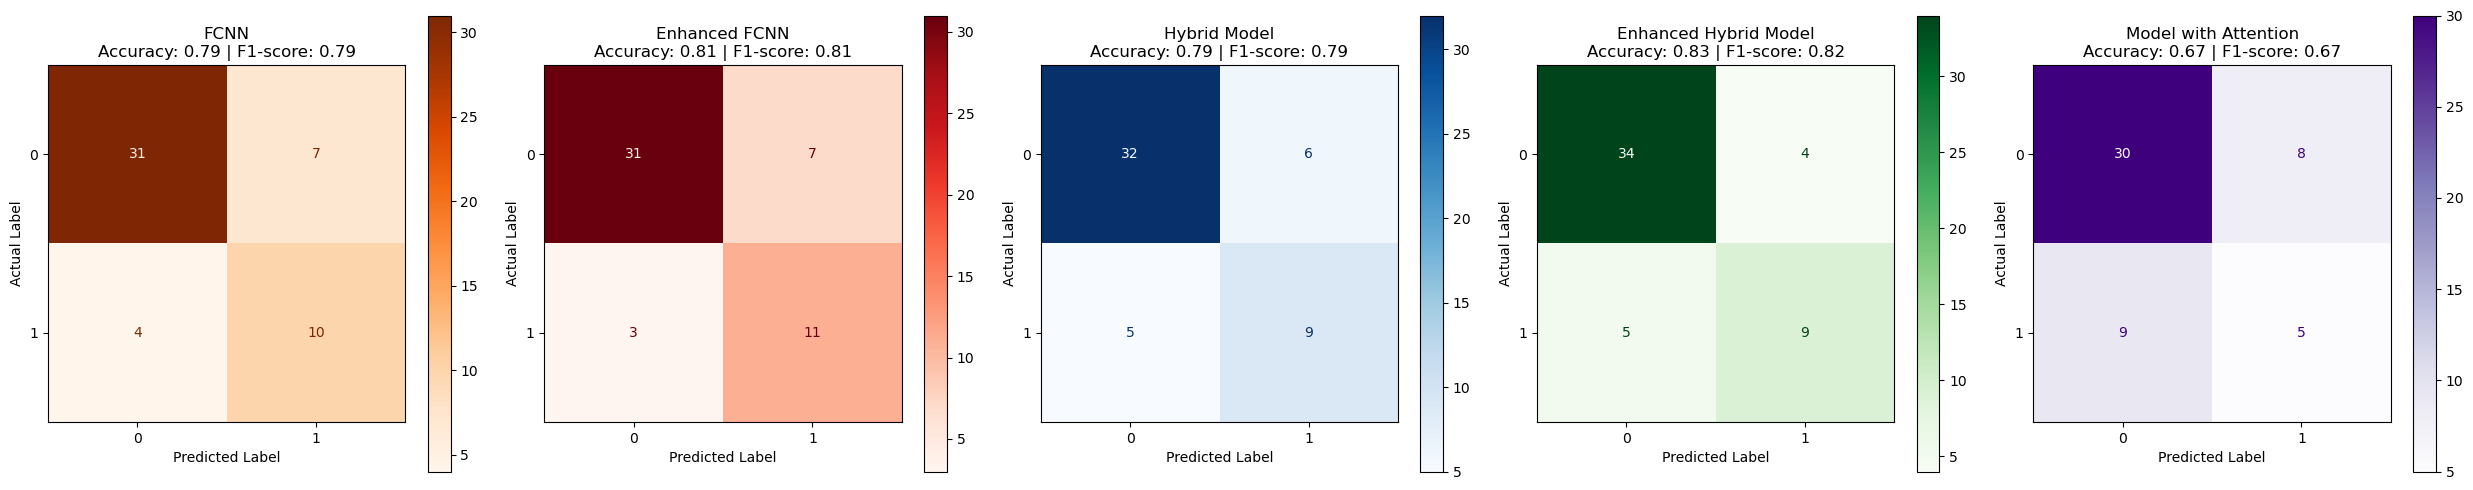

In [182]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Define a function to plot confusion matrix using ConfusionMatrixDisplay and compute F1-score
def plot_confusion_matrix_with_estimator(model, inputs, true_labels, model_name, ax, cmap):
    # Generate predictions and calculate metrics
    y_pred = model.predict(inputs)
    y_pred_classes = (y_pred > 0.5).astype(int)
    acc = model.evaluate(inputs, true_labels, verbose=0)[1]
    f1 = f1_score(true_labels, y_pred_classes, average='weighted')

    # Display the confusion matrix using sklearn's ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay.from_predictions(true_labels, y_pred_classes, cmap=cmap, ax=ax)
    disp.ax_.set_title(f'{model_name}\nAccuracy: {acc:.2f} | F1-score: {f1:.2f}')
    disp.ax_.set_xlabel('Predicted Label')
    disp.ax_.set_ylabel('Actual Label')

    return f1

# Set up a figure for plotting
fig, ax = plt.subplots(1, 5, figsize=(25, 5))  # Change here for a single row layout

# Dictionary to store F1-scores
f1_scores = {}

# Different color maps for each model
color_maps = ['Oranges', 'Reds', 'Blues', 'Greens', 'Purples']

# Plot confusion matrices for different models with different color maps
f1_scores['FCNN'] = plot_confusion_matrix_with_estimator(model_FCNN, X_test_combined, y_test_combined, 'FCNN', ax[0], color_maps[0])
f1_scores['Enhanced FCNN'] = plot_confusion_matrix_with_estimator(model_ehFCNN, X_test_combined, y_test_combined, 'Enhanced FCNN', ax[1], color_maps[1])
f1_scores['Hybrid Model'] = plot_confusion_matrix_with_estimator(model_hb, [X_test_text, X_test_audio], y_test_combined, 'Hybrid Model', ax[2], color_maps[2])
f1_scores['Enhanced Hybrid Model'] = plot_confusion_matrix_with_estimator(model_ehhb, [X_test_text, X_test_audio], y_test_combined, 'Enhanced Hybrid Model', ax[3], color_maps[3])
f1_scores['Model with Attention'] = plot_confusion_matrix_with_estimator(model_with_attention, [X_test_text, X_test_audio], y_test_combined, 'Model with Attention', ax[4], color_maps[4])

plt.tight_layout()
plt.savefig('../image/dnn_combine_diffmodel_confusion.png')
plt.show()

2/2 [==============================] - 0s 847us/step


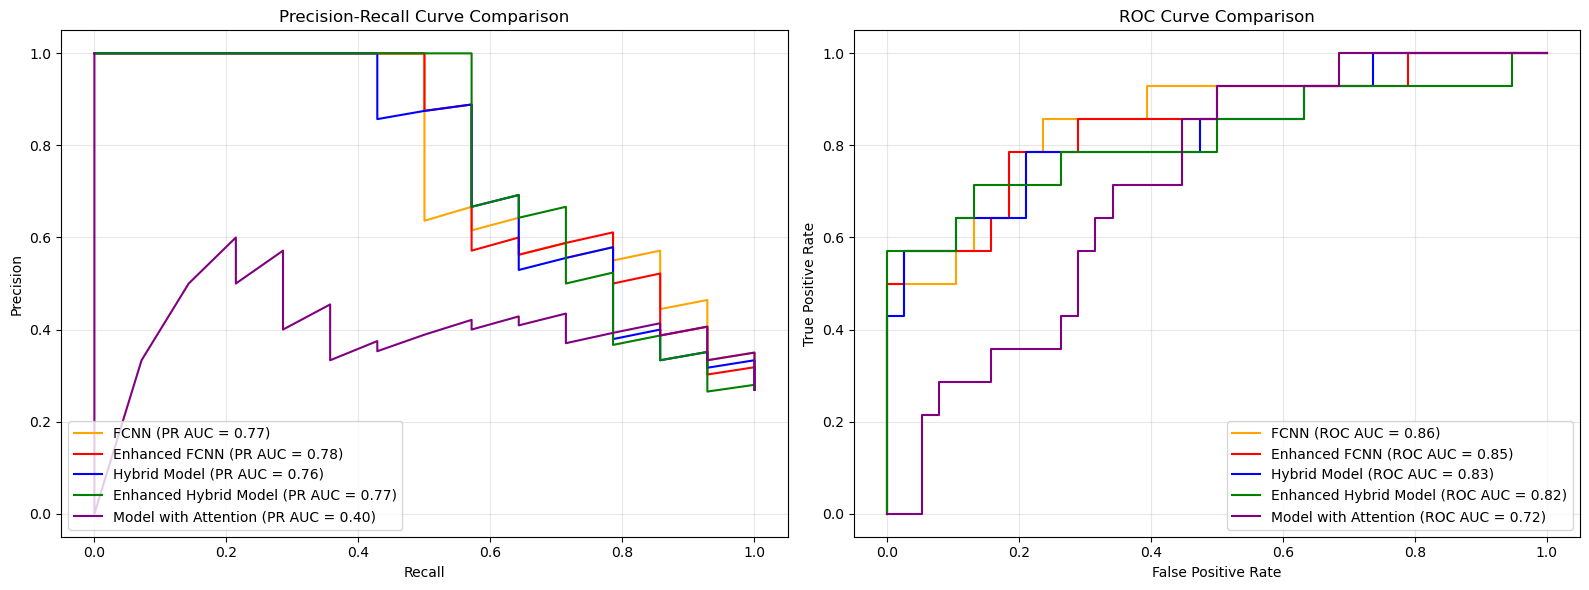

In [200]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, model_probs, model_name, ax, color):
    fpr, tpr, _ = roc_curve(y_true, model_probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, label=f'{model_name} (ROC AUC = {roc_auc:.2f})')  # Updated label for clarity
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Comparison')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)  # Added grid for better visibility

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, model_probs, model_name, ax, color):
    precision, recall, _ = precision_recall_curve(y_true, model_probs)
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, label=f'{model_name} (PR AUC = {pr_auc:.2f})')  # Updated label for clarity
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve Comparison')
    ax.legend(loc='lower left')
    ax.grid(alpha=0.3)  # Added grid for better visibility

# Set up a figure for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define model details for plotting
colors = ['orange', 'red', 'blue', 'green', 'purple']
models = [model_FCNN, model_ehFCNN, model_hb, model_ehhb, model_with_attention]
model_names = ['FCNN', 'Enhanced FCNN', 'Hybrid Model', 'Enhanced Hybrid Model', 'Model with Attention']
input_sets = [X_test_combined, X_test_combined, [X_test_text, X_test_audio], [X_test_text, X_test_audio], [X_test_text, X_test_audio]]

# Plot curves for each model
for model, model_name, color, input_set in zip(models, model_names, colors, input_sets):
    y_probs = model.predict(input_set)[:, 0]  # Adjust index if needed
    plot_precision_recall_curve(y_test_combined, y_probs, model_name, ax1, color)
    plot_roc_curve(y_test_combined, y_probs, model_name, ax2, color)

plt.tight_layout()
plt.savefig('../image/dnn_combined_curves.png')
plt.show()

2/2 [==============================] - 0s 779us/step


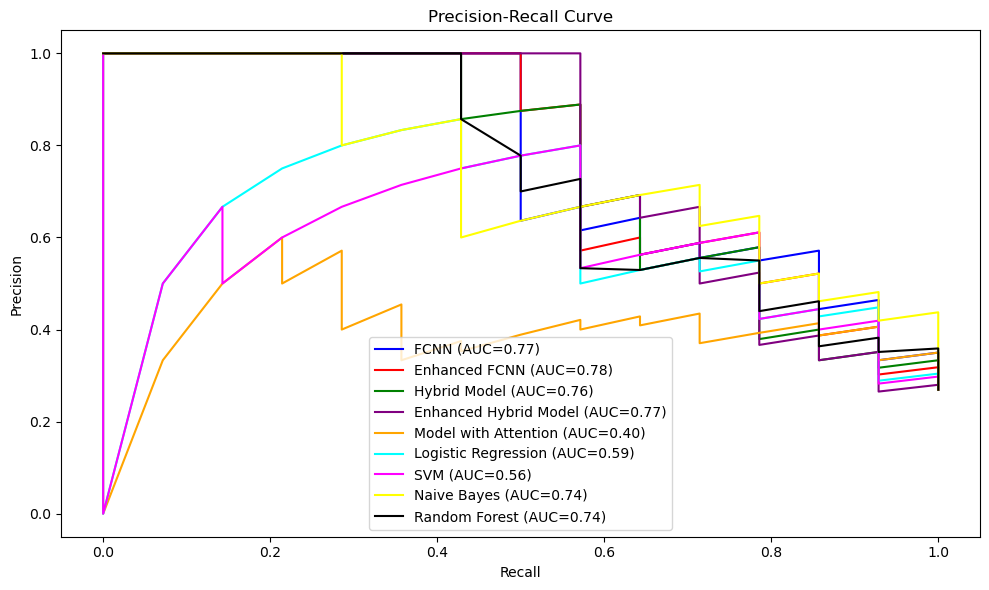

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, model_probs, model_name, ax, color):
    precision, recall, _ = precision_recall_curve(y_true, model_probs)
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, label=f'{model_name} (AUC={pr_auc:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='best')

# Set up a figure for the plots
fig, ax = plt.subplots(figsize=(10, 6))

# Compute probabilities and plot curve for each model
# Neural Network models
y_probs_FCNN = model_FCNN.predict(X_test_combined)[:, 0]  # Adjust index if needed
plot_precision_recall_curve(y_test_combined, y_probs_FCNN, 'FCNN', ax, 'blue')

y_probs_ehFCNN = model_ehFCNN.predict(X_test_combined)[:, 0]
plot_precision_recall_curve(y_test_combined, y_probs_ehFCNN, 'Enhanced FCNN', ax, 'red')

y_probs_hb = model_hb.predict([X_test_text, X_test_audio])[:, 0]
plot_precision_recall_curve(y_test_combined, y_probs_hb, 'Hybrid Model', ax, 'green')

y_probs_ehhb = model_ehhb.predict([X_test_text, X_test_audio])[:, 0]
plot_precision_recall_curve(y_test_combined, y_probs_ehhb, 'Enhanced Hybrid Model', ax, 'purple')

y_probs_attention = model_with_attention.predict([X_test_text, X_test_audio])[:, 0]
plot_precision_recall_curve(y_test_combined, y_probs_attention, 'Model with Attention', ax, 'orange')

# Traditional models using sklearn
y_probs_logistic = logistic_model_combined.predict_proba(X_test_combined)[:, 1]
plot_precision_recall_curve(y_test_combined, y_probs_logistic, 'Logistic Regression', ax, 'cyan')

y_probs_svm = svm_model.predict_proba(X_test_combined)[:, 1]
plot_precision_recall_curve(y_test_combined, y_probs_svm, 'SVM', ax, 'magenta')

y_probs_nb = nb_model.predict_proba(X_test_combined)[:, 1]
plot_precision_recall_curve(y_test_combined, y_probs_nb, 'Naive Bayes', ax, 'yellow')

y_probs_clf = clf_model.predict_proba(X_test_combined)[:, 1]
plot_precision_recall_curve(y_test_combined, y_probs_clf, 'Random Forest', ax, 'black')

plt.tight_layout()
plt.savefig('../image/precision_recall_curves.png')
plt.show()

2/2 [==============================] - 0s 874us/step


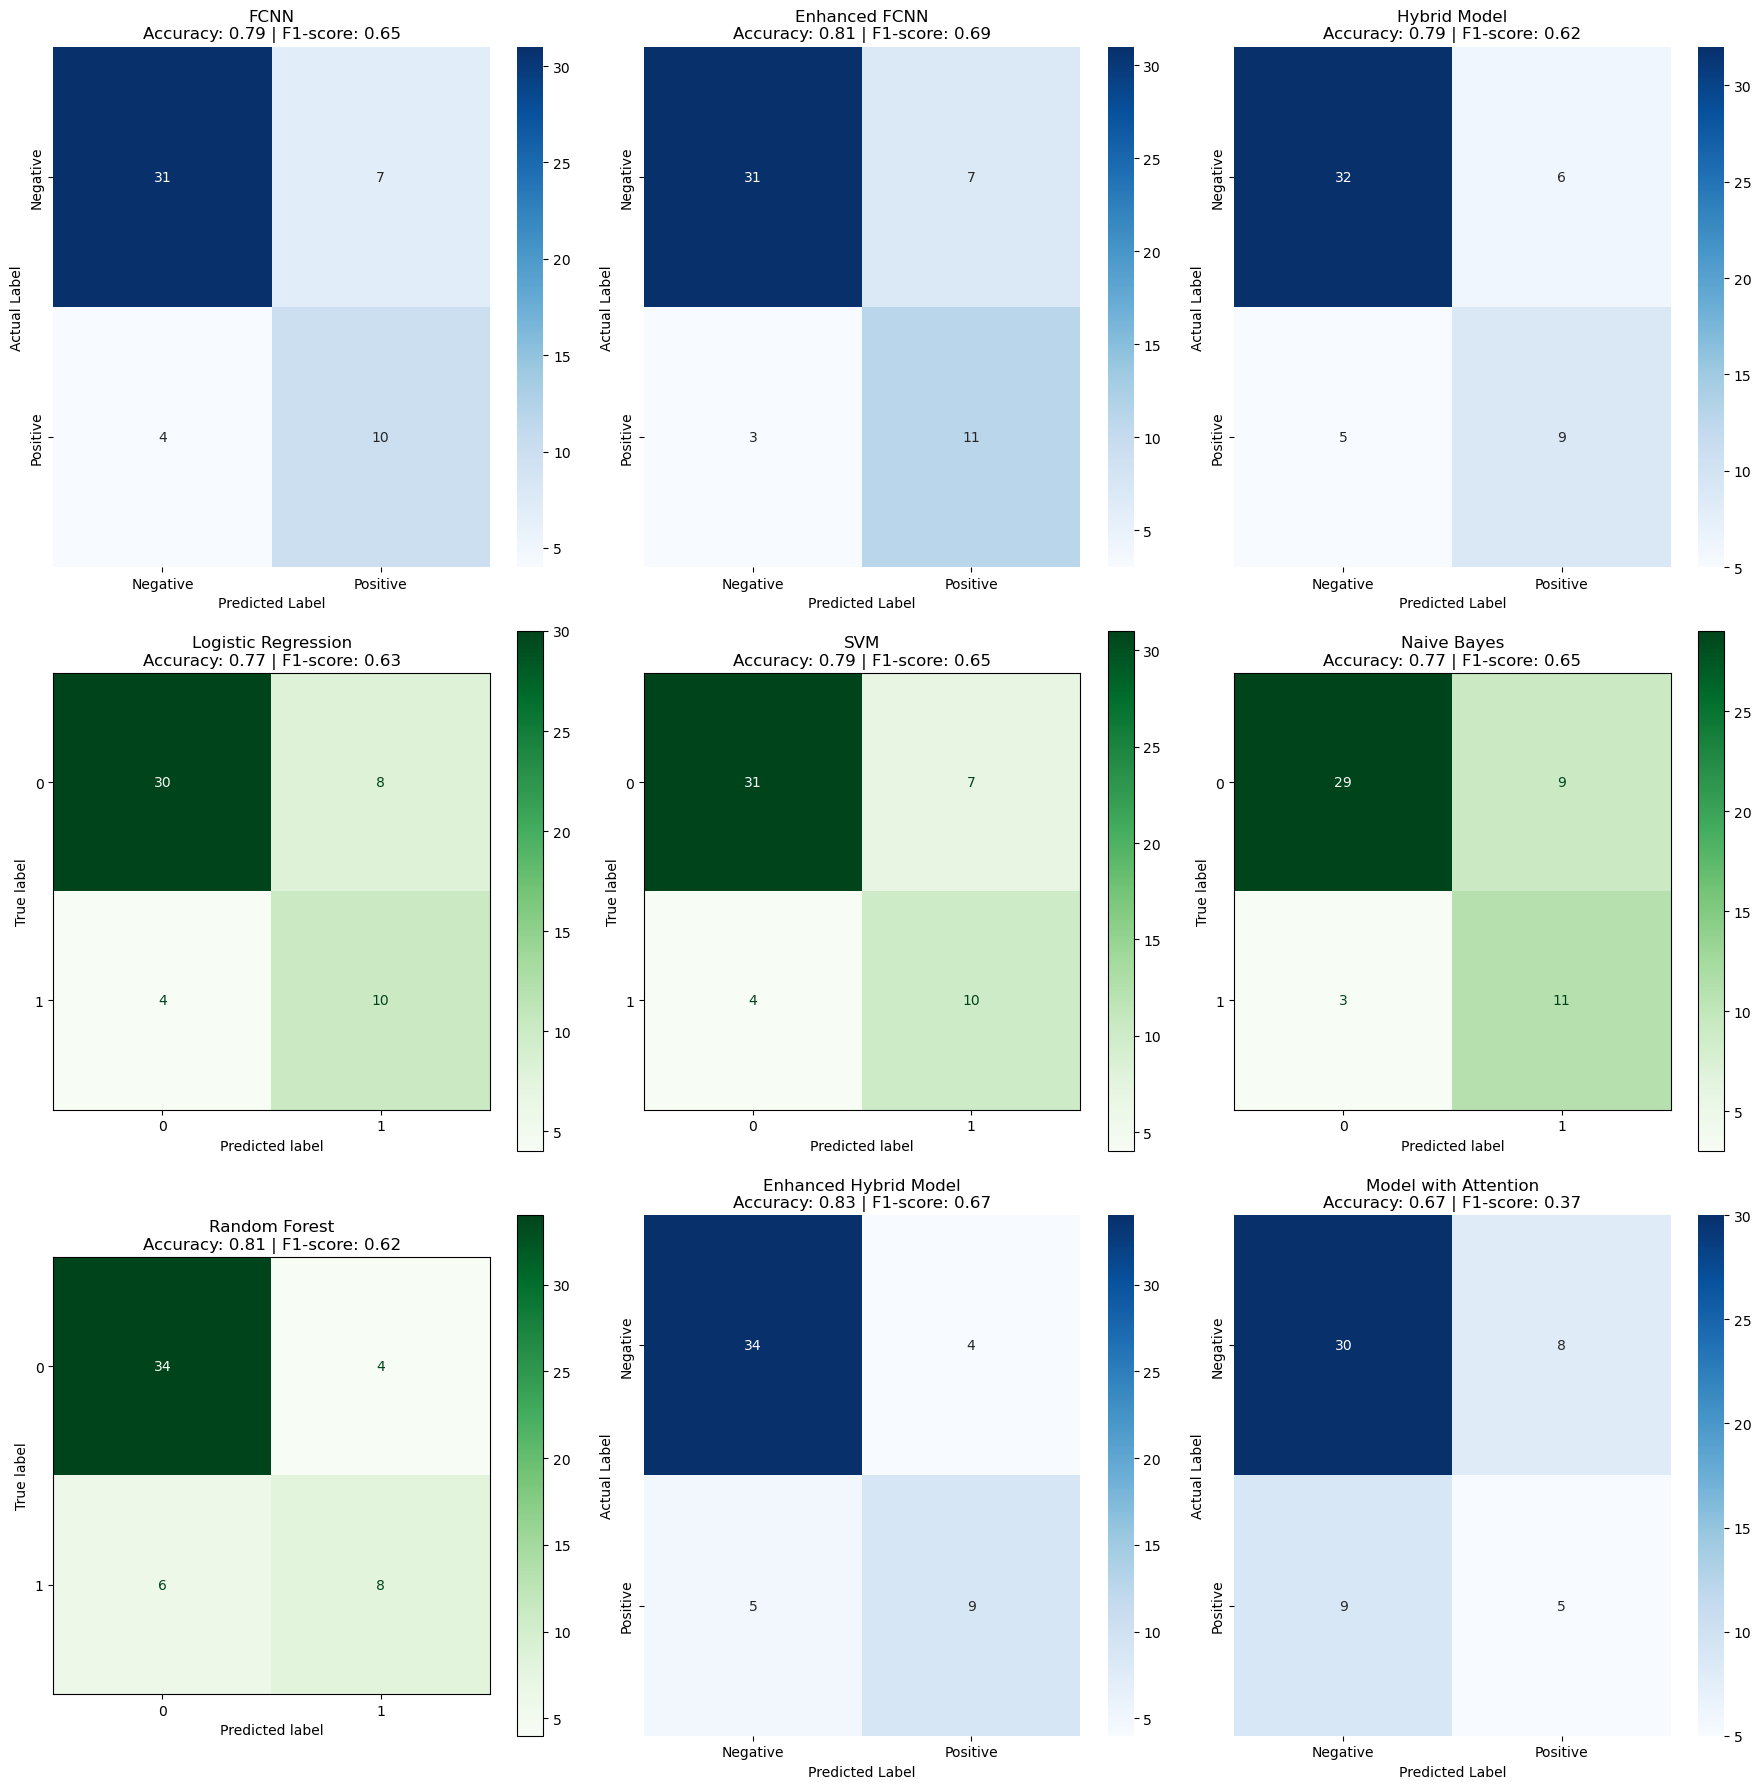

In [66]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Define a function to plot confusion matrix and compute F1-score
def plot_confusion_matrix(model, inputs, true_labels, model_name, ax):
    y_pred = model.predict(inputs)
    y_pred_classes = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(true_labels, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    acc = model.evaluate(inputs, true_labels, verbose=0)[1]
    f1 = f1_score(true_labels, y_pred_classes)
    ax.set_title(f'{model_name}\nAccuracy: {acc:.2f} | F1-score: {f1:.2f}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    return f1

# Set up a figure for plotting
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
ax = ax.flatten()

# Dictionary to store F1-scores
f1_scores = {}

# Plot confusion matrices for different models
f1_scores['FCNN'] = plot_confusion_matrix(model_FCNN, X_test_combined, y_test_combined, 'FCNN', ax[0])
f1_scores['Enhanced FCNN'] = plot_confusion_matrix(model_ehFCNN, X_test_combined, y_test_combined, 'Enhanced FCNN', ax[1])
f1_scores['Hybrid Model'] = plot_confusion_matrix(model_hb, [X_test_text, X_test_audio], y_test_combined, 'Hybrid Model', ax[2])

# F1-scores for traditional models
f1_scores['Logistic Regression'] = f1_score(y_test_combined, logistic_model_combined.predict(X_test_combined))
f1_scores['SVM'] = f1_score(y_test_combined, svm_model.predict(X_test_combined))
f1_scores['Naive Bayes'] = f1_score(y_test_combined, nb_model.predict(X_test_combined))
f1_scores['Random Forest'] = f1_score(y_test_combined, clf_model.predict(X_test_combined))

# Display for traditional models
ConfusionMatrixDisplay.from_estimator(logistic_model_combined, X_test_combined, y_test_combined, cmap='Greens', ax=ax[3])
ax[3].set_title(f'Logistic Regression\nAccuracy: {logistic_model_combined.score(X_test_combined, y_test_combined):.2f} | F1-score: {f1_scores["Logistic Regression"]:.2f}')

ConfusionMatrixDisplay.from_estimator(svm_model, X_test_combined, y_test_combined, cmap='Greens', ax=ax[4])
ax[4].set_title(f'SVM\nAccuracy: {svm_model.score(X_test_combined, y_test_combined):.2f} | F1-score: {f1_scores["SVM"]:.2f}')

ConfusionMatrixDisplay.from_estimator(nb_model, X_test_combined, y_test_combined, cmap='Greens', ax=ax[5])
ax[5].set_title(f'Naive Bayes\nAccuracy: {nb_model.score(X_test_combined, y_test_combined):.2f} | F1-score: {f1_scores["Naive Bayes"]:.2f}')

ConfusionMatrixDisplay.from_estimator(clf_model, X_test_combined, y_test_combined, cmap='Greens', ax=ax[6])
ax[6].set_title(f'Random Forest\nAccuracy: {clf_model.score(X_test_combined, y_test_combined):.2f} | F1-score: {f1_scores["Random Forest"]:.2f}')

f1_scores['Enhanced Hybrid Model'] = plot_confusion_matrix(model_ehhb, [X_test_text, X_test_audio], y_test_combined, 'Enhanced Hybrid Model', ax[7])
f1_scores['Model with Attention'] = plot_confusion_matrix(model_with_attention, [X_test_text, X_test_audio], y_test_combined, 'Model with Attention', ax[8])

plt.tight_layout()
plt.savefig('../image/combine_diffmodel_confusion.png')
plt.show()